--------------------------------------------
## Main

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
from pyspark.sql import SparkSession
# import findspark
import pyspark
import random
import pyspark.pandas as ps
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Word2Vec, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print('spark:', pyspark.__version__)
sns.set_style("darkgrid")
spark = SparkSession \
    .builder \
    .appName("hw4") \
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

spark: 3.3.1


In [4]:
PATH = 'drive/MyDrive/MADE/dataset/train.csv'
df = spark.read.csv(PATH, header=True, multiLine=True, inferSchema=True, escape='"', sep=',', encoding = "utf8")
df = df[['id', 'comment_text', 'toxic']]

df_train, df_val = df.randomSplit([0.8, 0.2], seed=42)
df.show()

+----------------+--------------------+-----+
|              id|        comment_text|toxic|
+----------------+--------------------+-----+
|0000997932d777bf|Explanation\nWhy ...|    0|
|000103f0d9cfb60f|D'aww! He matches...|    0|
|000113f07ec002fd|Hey man, I'm real...|    0|
|0001b41b1c6bb37e|"\nMore\nI can't ...|    0|
|0001d958c54c6e35|You, sir, are my ...|    0|
|00025465d4725e87|"\n\nCongratulati...|    0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|
|00031b1e95af7921|Your vandalism to...|    0|
|00037261f536c51d|Sorry if the word...|    0|
|00040093b2687caa|alignment on this...|    0|
|0005300084f90edc|"\nFair use ratio...|    0|
|00054a5e18b50dd4|bbq \n\nbe a man ...|    0|
|0005c987bdfc9d4b|Hey... what is it...|    1|
|0006f16e4e9f292e|Before you start ...|    0|
|00070ef96486d6f9|Oh, and the girl ...|    0|
|00078f8ce7eb276d|"\n\nJuelz Santan...|    0|
|0007e25b2121310b|Bye! \n\nDon't lo...|    1|
|000897889268bc93|REDIRECT Talk:Voy...|    0|
|0009801bd85e5806|The Mitsurugi po

## Анализ данных
Данные содержат много специальных символов, которые необходимо удалить для корректной работы модели W2V.

Можно заметить, что в данных большой перевес одного класса, примерно 10:1. В данной работе бороться с этим не будем, так как цель работы познакомиться с фреймворком, а не добиться отличного качества метрики.

##TF-IDF approach

In [5]:
def train_tfidf_model(df_train, df_val, num_features):
    tokenizer = RegexTokenizer(inputCol="comment_text", outputCol="words", pattern="\\W")
    hashing_tf = HashingTF(inputCol="words", outputCol="tf", numFeatures=num_features)
    idf = IDF(inputCol="tf", outputCol="features")
    lr = LogisticRegression(featuresCol='features', labelCol='toxic', regParam=0.3)
    pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, lr])
    evaluator = MulticlassClassificationEvaluator(labelCol="toxic", predictionCol="prediction", metricName='f1')

    model = pipeline.fit(df_train)
    df_val = model.transform(df_val)
    f1 = evaluator.evaluate(df_val)
    return round(f1, 5)


100%|██████████| 8/8 [06:23<00:00, 47.91s/it]


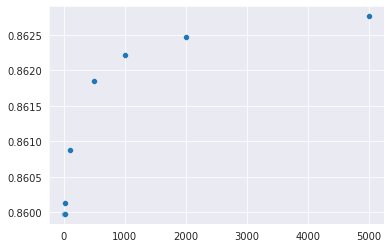

In [6]:
metrics = []
features = [5, 10, 20, 100, 500, 1000, 2000, 5000]
for i in tqdm(features):
    f1 = train_tfidf_model(df_train, df_val, i)
    metrics.append(f1)

sns.scatterplot(x=features, y=metrics);

####Вывод
Параметр numFeatures в HashingTF слабо влияет на качество f1 метрики.

С повышением параметра имеется прирост порядка сотых единиц (0.860 и 0.862, при параметрах 5 и 5000), что, конечно тоже можно использовать для оптимизации.




##W2V approach

In [7]:
def train_w2v_model(df_train, df_val, vector_size):
    tokenizer = RegexTokenizer(inputCol="comment_text", outputCol="words", pattern="\\W")
    w2v = Word2Vec(vectorSize=vector_size, minCount=0, inputCol="words", outputCol="features")
    lr = LogisticRegression(featuresCol='features', labelCol='toxic', regParam=0.3)
    pipeline = Pipeline(stages=[tokenizer, w2v, lr])
    evaluator = MulticlassClassificationEvaluator(labelCol="toxic", predictionCol="prediction", metricName='f1')

    model = pipeline.fit(df_train)
    df_val = model.transform(df_val)
    f1 = evaluator.evaluate(df_val)
    return round(f1, 5)

100%|██████████| 5/5 [29:47<00:00, 357.42s/it]


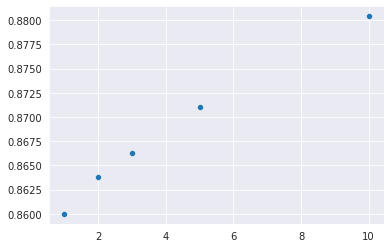

In [8]:
metrics = []
features = [1, 2, 3, 5, 10]
for i in tqdm(features):
    f1 = train_w2v_model(df_train, df_val, i)
    metrics.append(f1)

sns.scatterplot(x=features, y=metrics);

####Вывод
Параметр vectorSize в W2V сильно влияет на качество метрики f1.

С повышением параметра имеется прирост порядка десятых единиц (0.86 и 0.88, при параметрах 1 и 10).

Из-за большой длительности обучения дальнейшая оптимизация не проводилась.


##Вывод по работе
В данной работе решалась задача классификации [комментариев](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classiﬁcation-challenge/data) с помощью фреймворка spark. Оценивалась метрика f1.

Проанализированы 2 подхода:
- TF-IDF 
- WORD2VEC (оптимизировался параметр vectorSize)

В подходе TF-IDF оптимизировался параметр numFeatures, лучшая метрика **0.863**

В подходе WORD2VEC оптимизировался параметр vectorSize, лучшая метрика **0.880**

В итоге оба подхода дали сравнимые результаты, TF-IDF работает быстрее, но проигрывает по качеству перед WORD2VEC.



